# LSO Handin 2 - Subset Selection Problem

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyomo

## Data Inspection

In [68]:
def get_data():
    df = pd.read_csv("CO2_economic.csv")
    X = df.drop(['CO2-GR', 'year'], axis=1).to_numpy()
    y = df['CO2-GR'].to_numpy()
    return df, X, y

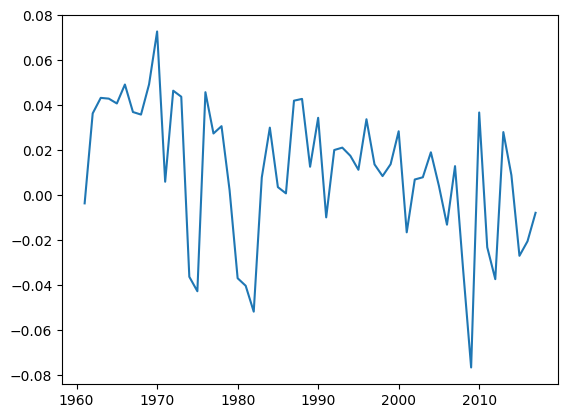

(57, 228)


,year,CO2-GR,FRED-MD-1,FRED-MD-2,FRED-MD-3,FRED-MD-4,FRED-MD-5,FRED-MD-6,FRED-MD-7,FRED-MD-8,...,US_Foreing_73,US_Foreing_74,US_Foreing_75,US_Foreing_76,US_CEMNT-1,US_CEMENT-2,US_TRANS-1,US_TRANS-2,US_TRANS-3,US_TRANS-4
0,1961,-0.003623,0.023464,-0.15530,-0.68443,-0.9180,-1.57080,-0.45069,-0.38606,-0.45797,...,0.716770,-0.60116,0.58925,-0.37866,-0.37213,-0.53299,-0.90675,-0.51371,-0.52343,-0.02997
1,1962,0.036385,0.985230,0.96994,0.93210,0.7986,0.43366,1.27100,1.31310,1.47760,...,-0.057105,0.23945,-0.52090,-0.17336,0.74256,0.65670,0.71695,-0.29572,0.12885,0.21633


In [70]:
df, X, y = get_data()

plt.plot(df['year'], df['CO2-GR'])
plt.show()

print(df.shape)
df.head(2)

In [242]:
df, X, y = get_data()
features = set(j for j in range(0, X.shape[1]))

In [258]:
def compute_beta(X, y, selected_features):

    selected_indicies = list(selected_features)

    X_k = X[:, selected_indicies]

    beta = np.zeros(shape=X.shape[1])
    beta_k, cost, *_ = np.linalg.lstsq(X_k, y, rcond=None)
    beta[selected_indicies] = beta_k

    # cost
    if len(cost) == 0:
        residuals = y - np.matmul(X_k, beta_k)
        cost = [np.dot(residuals, residuals)]

    return beta, cost[0]

## Greedy LP solution

### LP-relaxation

In [280]:
def LP_model(X, y, k, LB, UB, solver, type):
    n = X.shape[0]
    p = X.shape[1]

    beta_list = list(range(1, p+1))

    if type == 'relaxation':
        z_type = pyomo.NonNegativeReals
    elif type == 'exact':
        z_type = pyomo.Binary
    else:
        raise ValueError

    lower_bound = [LB for j in beta_list]
    upper_bound = [UB for j in beta_list]

    model = pyomo.ConcreteModel()
    model.beta = pyomo.Var(beta_list, within=pyomo.Reals)
    model.z = pyomo.Var(beta_list, within=z_type, bounds=[0, 1])

    model.obj = pyomo.Objective(
        expr=sum([(y[i-1] - sum([X[i-1, j-1]*model.beta[j] for j in beta_list]))**2 for i in range(1, n+1)]),
        sense=pyomo.minimize
    )

    model.csts = pyomo.ConstraintList()
    model.csts.add(
        expr=sum([model.z[j] for j in beta_list]) <= k
    )
    for j in beta_list:
        model.csts.add(
            expr=lower_bound[j-1]*model.z[j] <= model.beta[j]
        )
        model.csts.add(
            expr=model.beta[j] <= upper_bound[j-1]*model.z[j]
        )

    solver.solve(model, tee=False)

    cost = pyomo.value(model.obj)
    beta = np.array([pyomo.value(model.beta[j]) for j in beta_list])
    z = np.array([pyomo.value(model.z[j]) for j in beta_list])

    return cost, beta, z

In [316]:
solver = pyomo.SolverFactory('cplex', executable='/Applications/CPLEX_Studio2211/cplex/bin/arm64_osx/cplex')

k = 10
cost_LP, beta_LP, z_LP = LP_model(X=X, y=y, k=k, LB=-100, UB=100, solver=solver, type='relaxation')
print(cost_LP)

0.003287069183264541


### Greedy construction

In [ ]:
def greedy_LP_solution(X, y, k):
    # LP-relaxation
    solver = pyomo.SolverFactory('cplex', executable='/Applications/CPLEX_Studio2211/cplex/bin/arm64_osx/cplex')
    cost_LP, beta_LP, z_LP = LP_model(X=X, y=y, k=k, LB=-100, UB=100, solver=solver, type='relaxation')

    # greedy choose features
    selected_features = set()
    order = np.argsort(z_LP)[::-1]

    for j in range(0, k):
        selected_features.add(order[j])

    # evaluate
    beta, cost = compute_beta(X=X, y=y, selected_features=selected_features)
    
    return beta, cost, selected_features

In [315]:
beta, cost, selected_features = greedy_LP_solution(X, y, k)
print(cost)
print(selected_features)

0.027501652907703324
{np.int64(99), np.int64(164), np.int64(100), np.int64(38), np.int64(49), np.int64(54), np.int64(183), np.int64(185), np.int64(126), np.int64(31)}


## Iterated Local Search

### Local Search

In [309]:
from copy import copy

def local_search(X, y, features, k, iteration_max):

    beta_initial, cost_initial, selected_features = greedy_LP_solution(X, y, k)
    unselected_features = features.difference(selected_features)

    cost_best = copy(cost_initial)
    beta_best = copy(beta_initial)

    for iteration in range(1, iteration_max+1):

        best_add = None
        best_remove = None

        for selected in selected_features:
            for unselected in unselected_features:
                selected_new = copy(selected_features)
                selected_new.remove(selected)
                selected_new.add(unselected)
                
                beta_new, cost_new = compute_beta(X, y, selected_new)
                
                # If new objective value is better, save it
                if cost_new < cost_best:
                    cost_best = cost_new
                    best_add = unselected
                    best_remove = selected
                    beta_best = beta_new

        if best_add is not None and best_remove is not None:
            selected_features.remove(best_remove)
            selected_features.add(best_add)
        else:
            break

    return selected_features, cost_best, beta_best, iteration

In [310]:
k = 10
beta_initial, cost_initial, selected_initial = greedy_LP_solution(X, y, k=k)
print(cost_initial)

selected_best, cost_best, beta_best, iteration = local_search(X=X, y=y, features=features, k=k, iteration_max=100)
print(cost_best)
print(iteration)

0.027501652907703324
0.011005123407696833
12


### Iterated Local Search